# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit
from functools import partial

np.set_printoptions(suppress=True)

In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [30]:
from boundary_conditions import bound_agent_position

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $b = 1, ..., B$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [5]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [6]:
@njit
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2
    
    return positions.astype(np.float32), rotations.astype(np.float32)

In [7]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size, num_agents=12)
agent_positions[0]

array([3.1853704, 4.8063965], dtype=float32)

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [8]:
@njit
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.
    
    Returns 
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [9]:
beacon_positions = initialize_beacons(num_beacons=1, room_sensing_range=world_size)
beacon_positions

array([[8.778167, 7.637956]], dtype=float32)

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [10]:
@njit
def external_influence( 
    agent_position,
    beacon_position,
    noise = False,
    noise_amplitude = 0.01
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    beacon_direction = np.arctan2(
        beacon_position[1] - agent_position[1], 
        beacon_position[0] - agent_position[0]
    )
    
    # Generate a random direction with drift around the target angle
    if noise:
        beacon_direction = beacon_direction + (np.random.random() - 0.5) * noise_amplitude
        # beacon_direction = beacon_direction + np.random.vonmises(0., 8.) * noise_amplitude
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(beacon_direction), np.sin(beacon_direction)], dtype=np.float32)
    
    return v

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [11]:
@njit 
def internal_influence(
        self_position,
        other_positions,
        other_rotations,
        sensing_radius = 1.5,
        focus = 0.01,
        noise = False
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    other_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    other_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
      
    neighbor_rotations = []
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])
        
    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    
    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)
    
    if noise:
        deviation = (np.random.random() - 0.5) * focus
    else:
        deviation = np.random.vonmises(mu=0., kappa=4.) * focus
    direction = averaged_rotation + deviation
    
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32) 
    
    return v

In [76]:
deviation = np.random.vonmises(mu=0., kappa=4.) * 1
deviation

0.8503257698385838

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [12]:
@njit
def count_neighbors(self_position, other_positions, sensing_radius = 1.5):
    """
    Helper function that counts the number of neighbors
    
    Parameters
    ----------
    self_position   : np.ndarray of size (2)
        The position of the agent itself
    other_positions : np.ndarray of size (num_agents, 2)
        The positions of all agents
    sensing_radius  : float, default: 1.5
        The sensing radius of the agent
        
    Returns 
    -------
    num_neighbors   : int, default: 0
        The number of neighbors within the agent's sensing radius.
    """
    
    num_neighbors = 0
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            num_neighbors += 1

    return num_neighbors

In [13]:
num_neighbors = count_neighbors(agent_positions[8], agent_positions)
num_neighbors

1

In [84]:
@njit
def combined_influences(
    agent_positions: np.ndarray = None, 
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    dt: float = 0.1, 
    influence_weight: float = 0.5,
    internal_focus: float = 0.1
):
    """
    Update the positions and orientations of a single agent 
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    beacon_positions : np.ndarray
        Positions of the beacons.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).
    external_focus : float, optional
        Concentration of the agent's rotational noise influenced by the beacons
    internal_focus : float, optional
        Concentration of the agent's rotational noise influenced by the neighbors

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    assert (len(agent_positions) == len(agent_rotations))
    
    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]
    
    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    num_neighbors = np.zeros((num_agents, ))
    
    
    for i in range(num_agents):
        
        num_neighbors[i] = count_neighbors(agent_positions[i], agent_positions)
        
        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []
        
        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)
        
        beacon_id = np.argmin(np.array(distance_to_beacon))
        
        ddm_vector = external_influence(
            agent_positions[i], 
            beacon_positions[beacon_id],
            #focus=external_focus
        )
        
        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
        
        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
        
        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)
        
        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt
        
        new_agent_positions[i] = bound_agent_position(new_agent_positions[i], room_size=room_size)
    
    return new_agent_positions, new_agent_rotations, num_neighbors

In [85]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations, num_neighbors = combined_influences(agent_positions, agent_rotations, beacon_positions)

In [86]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[ 1.92492771, -3.19895768,  2.00402286, -3.1377698 ],
       [-3.79919767,  0.99114537, -3.80821461,  1.09073802],
       [-2.87474251,  0.25438249, -2.94765622,  0.18594573],
       [-1.4355371 , -2.29041243, -1.33555656, -2.28843959],
       [ 2.10961676, -0.42917639,  2.02490503, -0.37603579],
       [-0.74979901,  2.62345123, -0.66474431,  2.57086133],
       [ 1.4720068 , -2.7106235 ,  1.37911807, -2.67358724],
       [ 2.66796494,  0.51054537,  2.58153765,  0.5608477 ],
       [ 2.72649431,  2.19095421,  2.62679795,  2.19874102],
       [-3.92840838,  0.58742404, -3.83200358,  0.56085124],
       [ 0.83440781,  4.09129238,  0.83123415,  4.19124201],
       [-0.8335011 , -3.78183079, -0.82649763, -3.68207633]])

In [87]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[0.82707328, 0.65843384],
       [1.74541152, 1.66108835],
       [4.01016712, 3.89532868],
       [6.24433422, 0.01972964],
       [2.76541567, 2.58133324],
       [5.68330336, 5.7294136 ],
       [2.66693902, 2.76219326],
       [2.79911733, 2.61449938],
       [2.9712851 , 3.06364558],
       [6.17763853, 6.0142263 ],
       [1.64941263, 1.60253817],
       [1.50581884, 1.50070421]])

In [88]:
num_neighbors

array([1., 2., 2., 0., 1., 0., 1., 1., 0., 2., 0., 0.])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [90]:
@njit
def simulator_fun(
    theta = None,
    num_agents: int = 12, 
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0, 
    dt: float = 0.001, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    internal_focus: float = 0.1,
    time_horizon: float = 30.
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    theta : np.ndarray
        Prior parameters specifying the internal properties of the agents
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    
    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        #internal_focus = theta[3]
    
    
    num_timesteps = int(time_horizon / dt)

    # Apply radial bound with sigmoid transformation for the sensing radius
    # (r_min, r_max) = (1., 5.)
    # sensing_radius = r_min + (r_max - r_min) * (1. / (1. + np.exp(-sensing_radius)))
    
    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    neighbors = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations
    
    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs, num_neighbors = combined_influences(
            agent_positions=positions[t-1], 
            agent_rotations=rotations[t-1], 
            beacon_positions=beacon_positions, 
            velocity=velocity, 
            sensing_radius=sensing_radius, 
            dt=dt, 
            influence_weight=influence_weight,
            internal_focus=internal_focus
        )
        
        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
        neighbors[t] = num_neighbors
    
    neighbors[0] = neighbors[1]    
    
    rotations = rotations[:,:,np.newaxis]
    neighbors = neighbors[:,:,np.newaxis]

    return np.concatenate((positions, rotations, neighbors), axis=-1)

In [92]:
simulation = simulator_fun(num_agents=49)
simulation[:,:,-1]

array([[3., 2., 5., ..., 6., 1., 2.],
       [3., 2., 5., ..., 6., 1., 2.],
       [3., 2., 4., ..., 6., 1., 2.],
       ...,
       [8., 0., 6., ..., 3., 0., 7.],
       [8., 0., 6., ..., 3., 0., 7.],
       [8., 0., 6., ..., 3., 0., 7.]])

# Complete pooling priors

In [93]:
param_names = [
    r"$w$",
    r"$r$",
    r"$v$",
    # r"$\eta$",
    # r"$\kappa$"
]

In [94]:
@njit
def prior_fun():
    weight = np.random.beta(2, 2)
    radius = np.random.gamma(5, 1)
    v = np.random.beta(2, 2) * 2.
    #focus = np.random.beta(2, 5)
    return np.array([weight, radius, v])#, focus])

In [95]:
theta = prior_fun()
theta

array([0.71648404, 6.59380228, 1.08624434])

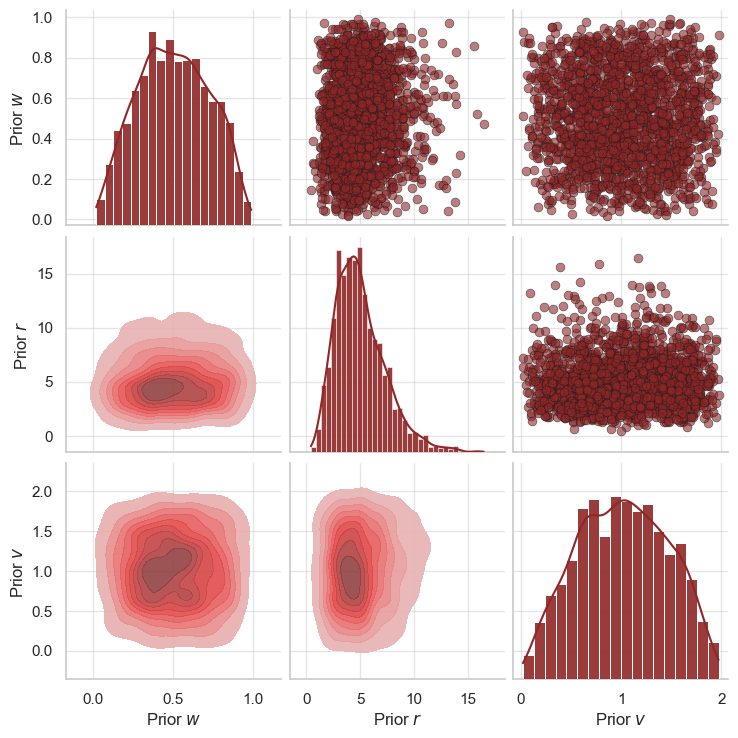

In [96]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
pp_check = prior.plot_prior2d()

In [97]:
test_simulation = simulator_fun(theta=theta)

# Generative Model

In [98]:
simulator = Simulator(simulator_fun=partial(simulator_fun, time_horizon=90, dt=1e-2))
simulator

In [99]:
model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False,
    name="TogetherFlow"
)

INFO:root:Performing 2 pilot runs with the TogetherFlow model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 9000, 12, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [100]:
out = model(1)
out['sim_data'][0,:,0].shape

(9000, 4)

# Configurator

In [101]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32, copy=False)
    
    x = input_dict['sim_data'] / 10. 
    
    if transpose:
        x = np.moveaxis(x, 2, 1)[:, :, ::10, :]
    
    output_dict['summary_conditions'] = x.astype(np.float32, copy=False)
    
    return output_dict

# Neural Approximator

In [105]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=256)),
    tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=5,
    coupling_design="spline",
    coupling_settings={
        'units': 128,
        'activation': 'swish',
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)

amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [106]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator,
    checkpoint_path="checkpoints/complete4"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Online Training

In [107]:
# Now it has changed to 100 epochs with 1000 steps each (100000 total)
history = trainer.train_online(epochs=30, batch_size=16, iterations_per_epoch=100)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

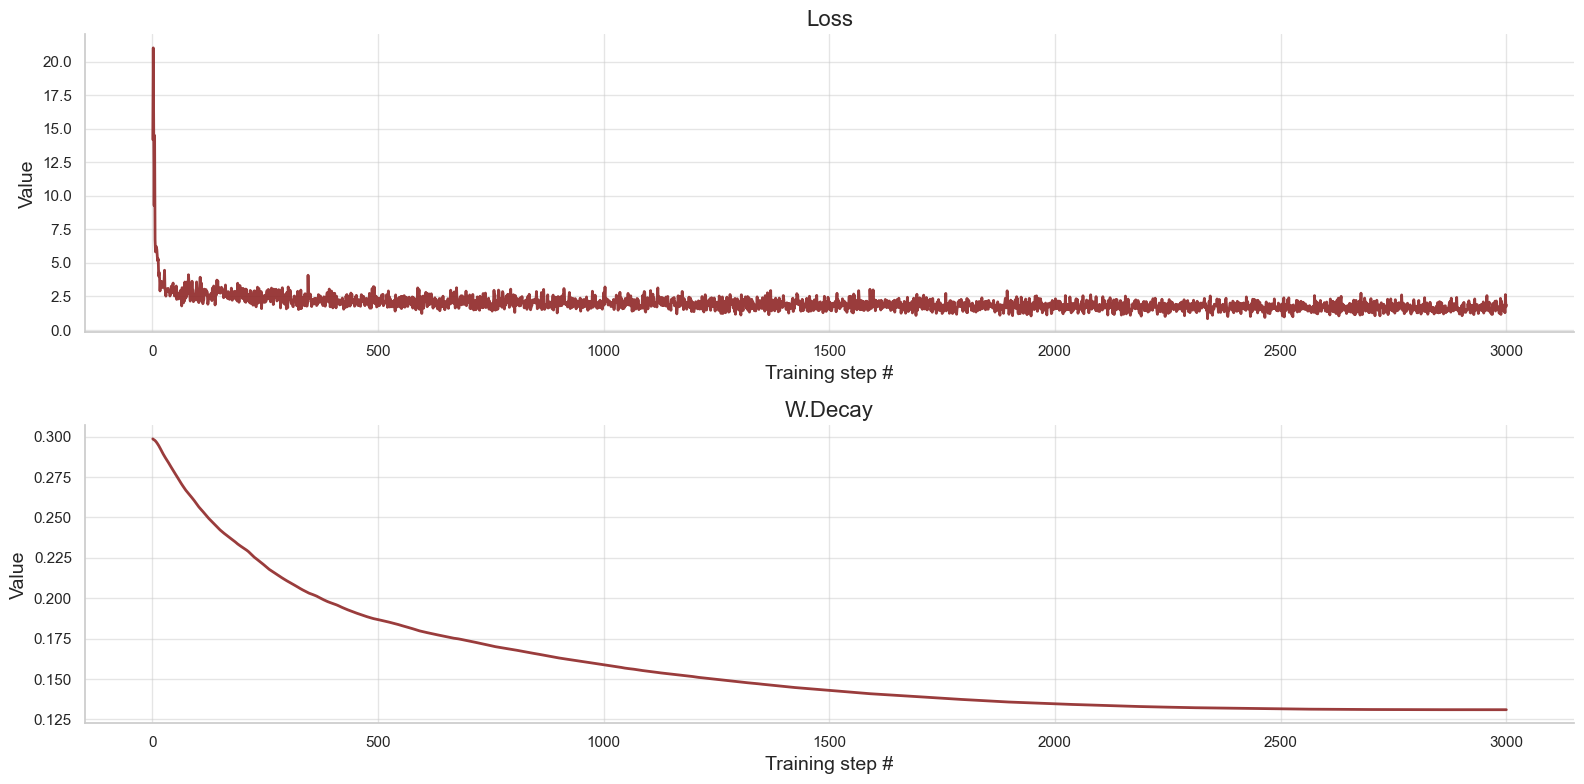

In [108]:
f = bf.diagnostics.plot_losses(history)

### Validation

In [109]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [110]:
validation_configured["parameters"]

array([[0.45372579, 3.8131874 , 1.2605606 ],
       [0.4008367 , 5.276966  , 0.80141354],
       [0.53767276, 4.5988584 , 0.41677272],
       ...,
       [0.46315208, 5.9294844 , 0.62763286],
       [0.6614774 , 4.112763  , 0.8452874 ],
       [0.32218033, 4.4387755 , 0.79863   ]], dtype=float32)

In [111]:
post_samples = amortizer.sample(validation_configured, n_samples=500)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

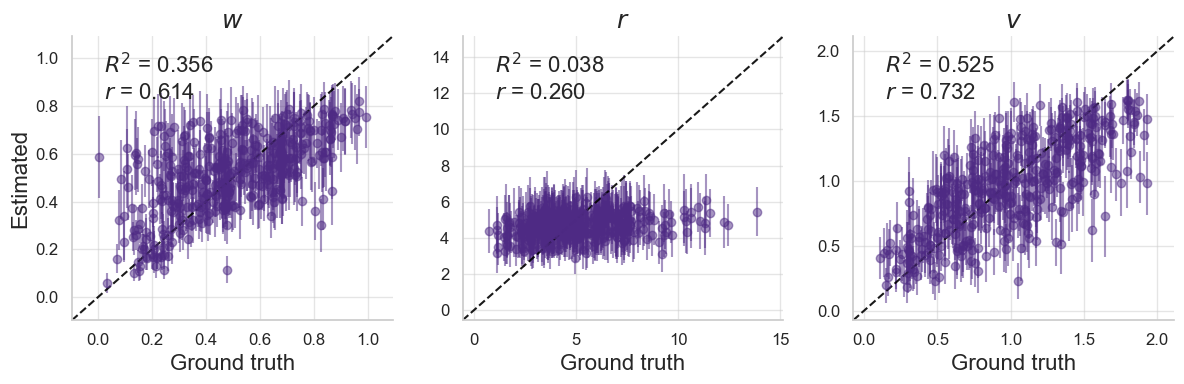

In [112]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    color="#4E2A84"
)

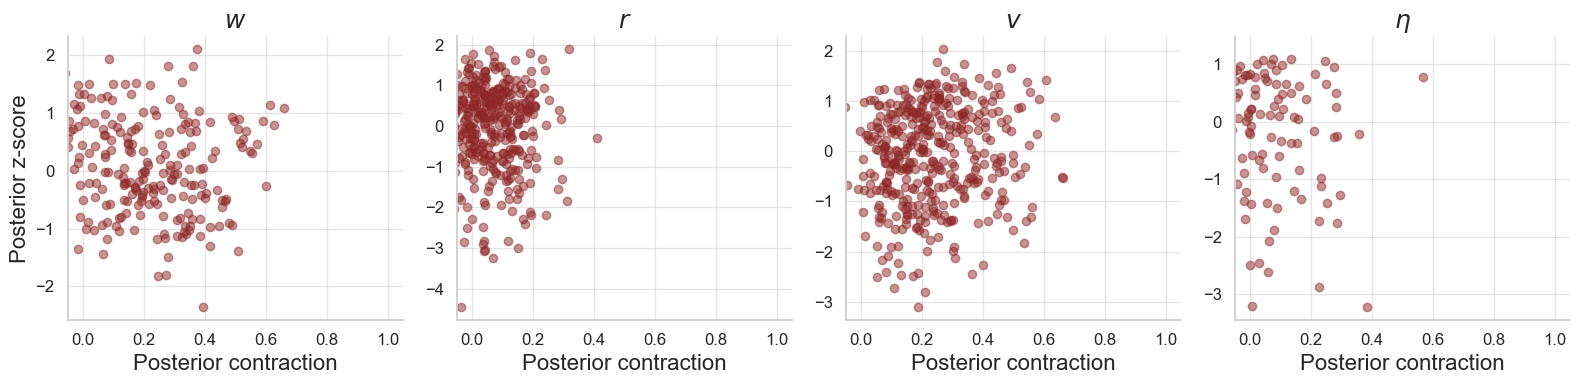

In [62]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

# SBC

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


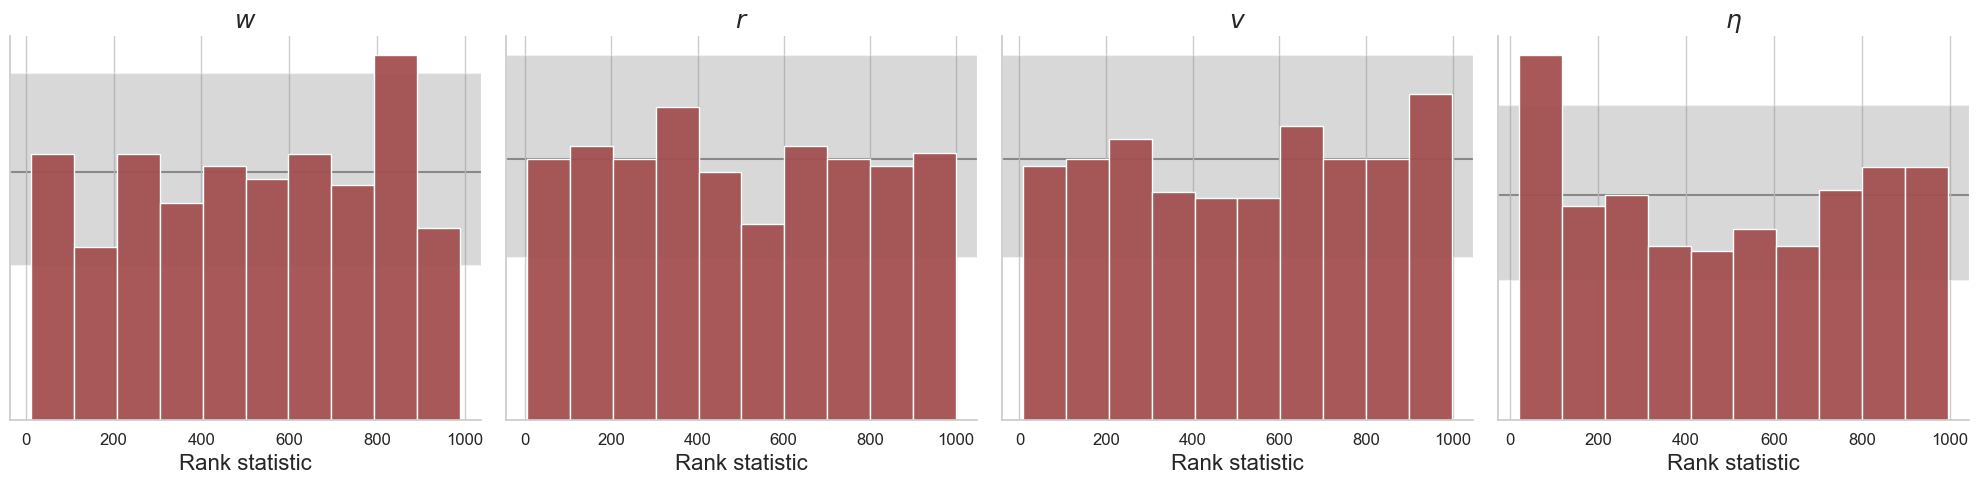

In [63]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10, )

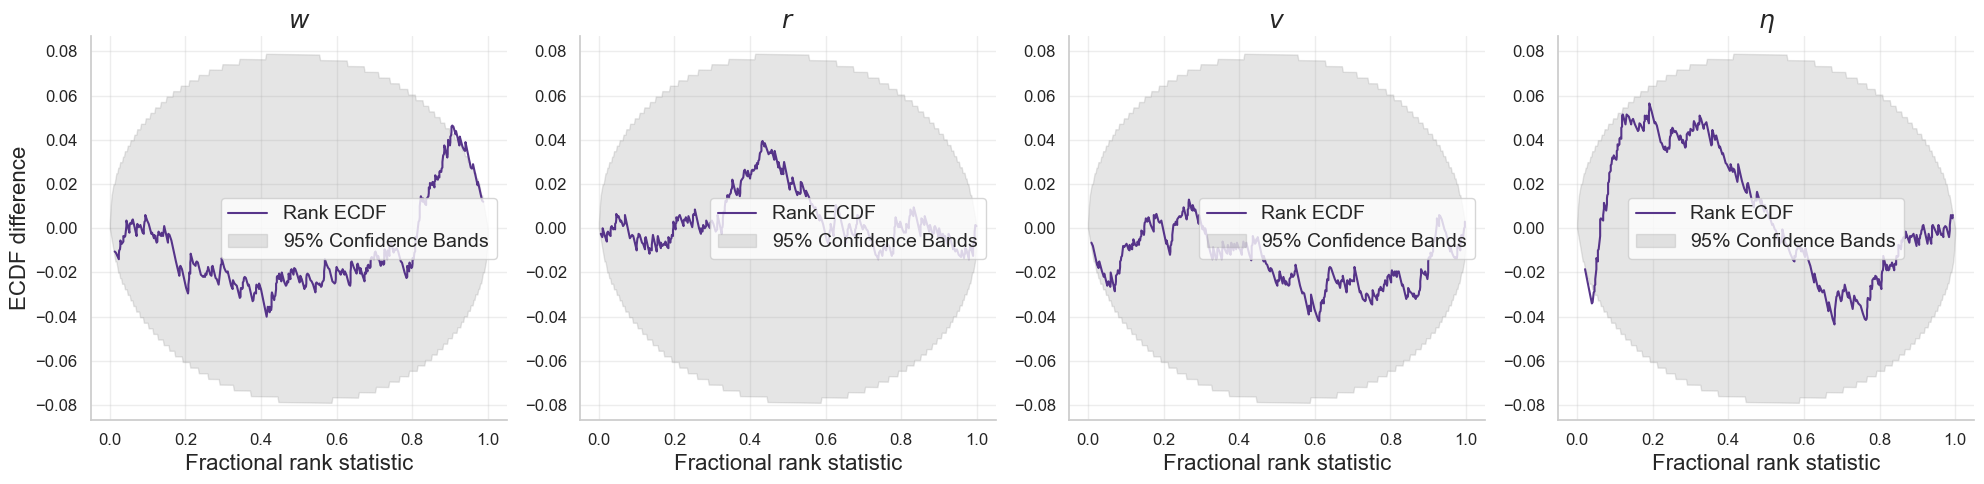

In [64]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84",
    difference=True
)

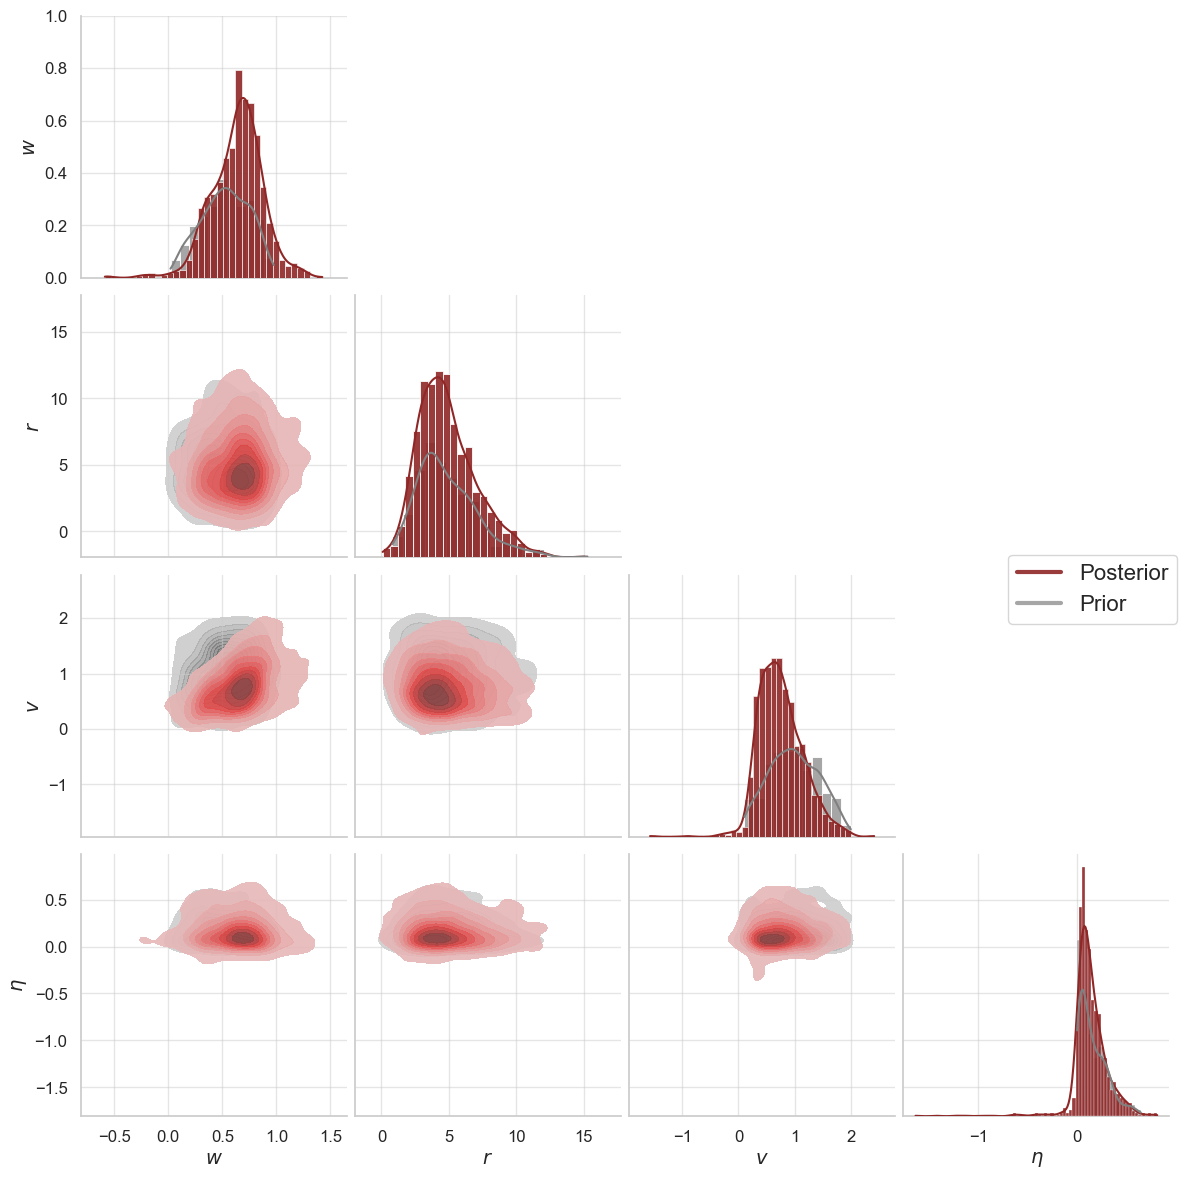

In [65]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)